## Advanced cancer networks and data

## Yihang Xin and Alex Pico

## 2021-01-05

## Installation

The following chunk of code installs the `py4cytoscape` module.

In [1]:
%%capture
!python3 -m pip install python-igraph requests pandas networkx
!python3 -m pip install wget
!python3 -m pip install py4cytoscape

## Import the required packages


In [2]:
import os
import sys
from time import sleep
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import py4cytoscape as p4c
import wget
from IPython.display import Image
%matplotlib inline
pd.options.mode.chained_assignment = None

## Setup Cytoscape
* Launch Cytoscape on your local machine. If you haven't already installed Cytoscape, then download the latest version from http://cytoscape.org.
* Install the STRING app, if you haven't already: http://apps.cytoscape.org/apps/stringapp
* Install the filetransfer app from https://apps.cytoscape.org/apps/filetransfer
* Leave Cytoscape running in the background during the remainder of the tutorial.
* Check cytoscape connection.

You can also install app inside Python notebook by running "py4cytoscape.install_app('Your App')"

In [3]:
p4c.cytoscape_version_info()

{'apiVersion': 'v1',
 'cytoscapeVersion': '3.8.2',
 'automationAPIVersion': '1.0.0',
 'py4cytoscapeVersion': '0.0.7'}

## Step 1: Getting Disease Networks

Use Cytoscape to query the STRING database for networks of genes associated with breast cancer and ovarian cancer.

### Query STRING database by disease to generate networks

#### Breast cancer

In [4]:
string_cmd_list = ['string disease query','disease="breast cancer"', 'species="Homo sapiens"', 'limit=150', 'cutoff=0.9']

In [5]:
string_cmd = " ".join(string_cmd_list)

In [6]:
p4c.commands.commands_run(string_cmd)

["Loaded network 'String Network - breast cancer' with 150 nodes and 882 edges"]

#### Ovarian cancer


In [7]:
string_cmd_list = ['string disease query','disease="ovarian cancer"', 'species="Homo sapiens"', 'limit=150', 'cutoff=0.9']

In [8]:
string_cmd = " ".join(string_cmd_list)

In [9]:
p4c.commands.commands_run(string_cmd)

["Loaded network 'String Network - ovarian cancer' with 150 nodes and 774 edges"]

## Step 2: Interacting with Cytoscape 

### Get list of networks 

In [10]:
p4c.get_network_list()

['String Network - ovarian cancer', 'String Network - breast cancer']

In [11]:
p4c.get_network_suid('String Network - ovarian cancer')

45814

In [12]:
p4c.get_network_suid('String Network - breast cancer')

43723

### Layout network

In [13]:
p4c.layout_network('circular', 'String Network - ovarian cancer')

{}

#### List of layout algorithms available

In [14]:
p4c.commands.cyrest_get('apply/layouts')

['attribute-circle',
 'stacked-node-layout',
 'degree-circle',
 'circular',
 'attributes-layout',
 'kamada-kawai',
 'force-directed',
 'cose',
 'grid',
 'hierarchical',
 'fruchterman-rheingold',
 'isom',
 'force-directed-cl']

In [15]:
p4c.layout_network('force-directed', 'String Network - ovarian cancer')

{}

#### Layout with parameters!

In [16]:
p4c.set_layout_properties('force-directed', {'defaultSpringLength': 5, 'defaultSpringCoefficient': .000004})

''

In [17]:
p4c.get_layout_property_names('force-directed')

['numIterations',
 'defaultSpringCoefficient',
 'defaultSpringLength',
 'defaultNodeMass',
 'isDeterministic',
 'singlePartition']

These *command* calls will allow you to interrogate the layouts and parameters available in your active Cytoscape session. This includes any layouts added by apps you've installed!

### Get table data from network
Now, let's look at the tablular data associated with our STRING networks...

In [18]:
p4c.get_table_column_names()

['SUID',
 'shared name',
 'name',
 'selected',
 'stringdb::canonical name',
 'display name',
 'stringdb::full name',
 'stringdb::database identifier',
 'stringdb::description',
 '@id',
 'stringdb::namespace',
 'stringdb::node type',
 'query term',
 'stringdb::sequence',
 'stringdb::species',
 'stringdb::STRING style',
 'stringdb::enhancedLabel Passthrough',
 'compartment::cytoskeleton',
 'compartment::cytosol',
 'compartment::endoplasmic reticulum',
 'compartment::endosome',
 'compartment::extracellular',
 'compartment::golgi apparatus',
 'compartment::lysosome',
 'compartment::mitochondrion',
 'compartment::nucleus',
 'compartment::peroxisome',
 'compartment::plasma membrane',
 'stringdb::structures',
 'target::development level',
 'target::family',
 'tissue::adrenal gland',
 'tissue::blood',
 'tissue::bone',
 'tissue::bone marrow',
 'tissue::eye',
 'tissue::gall bladder',
 'tissue::heart',
 'tissue::intestine',
 'tissue::kidney',
 'tissue::liver',
 'tissue::lung',
 'tissue::muscle',


#### Retrieve disease scores 
We can retrieve any set of columns from Cytoscape and store them as a data frame.

In [19]:
disease_score_table = p4c.get_table_columns(columns='stringdb::disease score')
disease_score_table.head()

,stringdb::disease score
45824,2.52159
45825,2.64927
45826,2.52018
45827,2.74756
45828,2.6126


Text(0, 0.5, 'frequency')

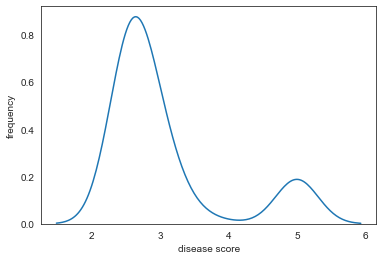

In [20]:
sns.set_style("white")
sns.kdeplot(data=disease_score_table["stringdb::disease score"].astype(float) )
plt.xlabel("disease score")
plt.ylabel("frequency")

### Generate subnetworks
In order to reflect your exploration back onto the network, let's generate subnetworks...

...from top quartile of 'disease score'

In [21]:
top_quart=disease_score_table["stringdb::disease score"].quantile(0.75)
top_nodes=disease_score_table[disease_score_table["stringdb::disease score"]>top_quart].index.tolist()
top_nodes = [str(n) for n in top_nodes]

In [22]:
p4c.create_subnetwork(nodes=top_nodes, subnetwork_name="top disease quartile")

47673

...of connected nodes only

In [23]:
p4c.create_subnetwork(nodes="selected", edges="all", subnetwork_name="top disease quartile connected")

47848

...from first neighbors of top 3 genes, using the network connectivity together with the data to direct discovery.

In [24]:
p4c.set_current_network("String Network - ovarian cancer")

{}

In [25]:
top_nodes=disease_score_table.sort_values(by=["stringdb::disease score"],\
                                         ascending=False)
top_nodes=top_nodes.index.tolist()[:3]
print(top_nodes)

[45872, 45878, 45854]


In [26]:
p4c.select_nodes(nodes=top_nodes)

{'nodes': [45872, 45878, 45854], 'edges': []}

In [27]:
p4c.select_first_neighbors()

{'nodes': [45872,
  45969,
  45877,
  45845,
  45878,
  45942,
  45946,
  45850,
  45883,
  45854,
  45855,
  45889,
  45827,
  45892,
  45956,
  45959,
  45897,
  45899,
  45963,
  45901],
 'edges': []}

In [28]:
p4c.create_subnetwork(nodes="selected", subnetwork_name="top disease neighbors")

48017

In [29]:
p4c.layout_network('force-directed', 'top disease neighbors')

{}

...from diffusion algorithm starting with top 3 genes, using the network connectivity in a more subtle way than just first-degree neighbors.

In [30]:
p4c.set_current_network("String Network - ovarian cancer")
p4c.select_nodes(nodes=top_nodes)

{'nodes': [45872, 45878, 45854], 'edges': []}

In [31]:
p4c.diffusion_basic()

{'heatColumn': 'diffusion_output_heat', 'rankColumn': 'diffusion_output_rank'}

In [32]:
p4c.create_subnetwork(nodes="selected", subnetwork_name="top disease diffusion")

48152

In [33]:
p4c.layout_network('force-directed', 'top disease diffusion')

{}

## Step 3: Visualizing data on networks

### Load datasets
Downloaded TCGA data from https://portal.gdc.cancer.gov/. Also available via each TCGA publication, e.g.:
 
* Breast: https://tcga-data.nci.nih.gov/docs/publications/brca_2012/
* Ovarian: https://tcga-data.nci.nih.gov/docs/publications/ov_2011/

Here we download TCGA data from our GitHub repo.

In [34]:
wget.download('https://raw.githubusercontent.com/cytoscape/cytoscape-automation/master/for-scripters/Python/data/brc.exp.tsv')
wget.download('https://raw.githubusercontent.com/cytoscape/cytoscape-automation/master/for-scripters/Python/data/brc.mut.tsv')

'brc.mut (1).tsv'

In [35]:
brc_expr=pd.read_table("./brc.exp.tsv")
brc_mut=pd.read_table("./brc.mut.tsv")

### Breast Cancer Datset
These datasets are similar to the data frames you normarlly encounter in R. For diversity, one using row.names to store corresponding gene names and the other uses the first column. Both are easy to import into Cytoscape.

In [36]:
brc_expr.head()

,expr.mean
ELMO2,-0.000167
CREB3L1,-0.005408
RPS11,0.018381
PNMA1,-0.065037
MMP2,-0.074444


In [37]:
brc_mut.head()

,Hugo_Symbol,mut_count,missense_mut_count
13,A1CF,2,2
14,A2BP1,3,3
15,A2M,3,2
16,A2ML1,4,4
17,A4GALT,1,0


Let's return to the Breast Cancer network...

In [38]:
p4c.set_current_network("String Network - breast cancer")
p4c.set_layout_properties('force-directed', {'defaultSpringLength': 5, 'defaultSpringCoefficient': .000004})

''

...and use the helper function from py4cytoscape called *load_table_data*


In [39]:
p4c.load_table_data(brc_expr, table_key_column='display name')
p4c.load_table_data(brc_mut, data_key_column='Hugo_Symbol', table_key_column='display name')

'Success: Data loaded in defaultnode table'

#### Visual styles
Let's create a new style to visualize our imported data
...starting with the basics, we will specify a few defaults and obvious mappings in a custom style all our own.

In [40]:
defaults = {'NODE_SHAPE': 'ellipse', 'NODE_SIZE': 60, 'NODE_FILL_COLOR':"#AAAAAA", 'EDGE_TRANSPARENCY': 120}
node_labels = p4c.map_visual_property('node label', 'display name', 'p')
p4c.create_visual_style('dataStyle', defaults=defaults, mappings=[node_labels])
p4c.set_visual_style('dataStyle')

{'message': 'Visual Style applied.'}

Now let's update the style with a mapping for mean expression. The first step is to grab the column data from Cytoscape and pull out the min and max to define our data mapping range of values.

In [41]:
brc_expr_network = p4c.get_table_columns(columns=['expr.mean'])

In [42]:
min_brc_expr = min(brc_expr_network.dropna()['expr.mean'].tolist())
max_brc_expr = max(brc_expr_network.dropna()['expr.mean'].tolist())

min_brc_expr=abs(min_brc_expr)
max_brc_expr=abs(max_brc_expr)

max_brc_expr=max([min_brc_expr,max_brc_expr])
min_brc_expr=max_brc_expr*-1.0

In python we check matplotlib's color maps to help us pick good colors to pair with our data values: https://matplotlib.org/examples/color/colormaps_reference.html

In [43]:
cmap = matplotlib.cm.get_cmap("bwr")
norm = matplotlib.colors.Normalize(vmin=min_brc_expr, vmax=max_brc_expr)
min_color=matplotlib.colors.rgb2hex(cmap(norm(min_brc_expr)))
center_color=matplotlib.colors.rgb2hex(cmap(norm(0)))
max_color=matplotlib.colors.rgb2hex(cmap(norm(max_brc_expr)))  
print(min_color, center_color, max_color)

#0000ff #fffefe #ff0000


In [44]:
NODE_FILL_COLOR = p4c.map_visual_property('node fill color', 'expr.mean', 'c', [min_brc_expr, 0.0, max_brc_expr], [min_color, center_color,max_color])
p4c.update_style_mapping('dataStyle', NODE_FILL_COLOR)
p4c.set_visual_style('dataStyle')

{'message': 'Visual Style applied.'}

Pro-tip: depending on your data, it may be better to balance your color range over negative and positive values bounded by the largest min or max data value, so that color intensity scales similarly in both directions.

#### Visualize mutation data
OK, now let's update with a mapping for mutation. Here are all the same steps, but this time mapping mutation counts to *both* node border width and color. 

In [45]:
brc_mut_network = p4c.get_table_columns(columns=['mut_count'])
min_brc_mut = min(brc_mut_network.dropna()['mut_count'].tolist())
max_brc_mut = max(brc_mut_network.dropna()['mut_count'].tolist())

cent_brc_mut=20.0

cmap = matplotlib.cm.get_cmap("Reds")
norm = matplotlib.colors.Normalize(vmin=min_brc_mut, vmax=max_brc_mut)
min_color=matplotlib.colors.rgb2hex(cmap(norm(min_brc_mut)))
center_color=matplotlib.colors.rgb2hex(cmap(norm(cent_brc_mut)))
max_color=matplotlib.colors.rgb2hex(cmap(norm(max_brc_mut)))  

In [46]:
NODE_BORDER_PAINT = p4c.map_visual_property('node border paint', 'mut_count', 'c', [min_brc_mut, 20, max_brc_mut], [min_color, center_color, max_color])
p4c.update_style_mapping('dataStyle', NODE_BORDER_PAINT)
p4c.set_visual_style('dataStyle')

{'message': 'Visual Style applied.'}

In [47]:
NODE_BORDER_WIDTH = p4c.map_visual_property('node border width', 'mut_count', 'c', [min_brc_mut, 20, max_brc_mut], [2, 4, 8])
p4c.update_style_mapping('dataStyle', NODE_BORDER_WIDTH)
p4c.set_visual_style('dataStyle')

{'message': 'Visual Style applied.'}

#### Subnetwork based on diffusion from heavily mutated nodes
Now, let's pull in what we learned about subnetwork selection and apply it here...

In [48]:
top_mut=brc_mut_network.dropna().sort_values(by=["mut_count"],ascending=False)
top_mut=top_mut.index.tolist()[:2]

In [49]:
p4c.select_nodes(nodes=top_nodes)

{}

In [50]:
p4c.diffusion_basic()

{'heatColumn': 'diffusion_output_heat', 'rankColumn': 'diffusion_output_rank'}

In [51]:
p4c.create_subnetwork(nodes="selected", subnetwork_name="top mutated diffusion")

48232

In [52]:
p4c.layout_network('force-directed', 'top disease diffusion')

{}

The top mutated genes are based on TCGA data and the diffusion algorithm is operating based on the network connectivity from STRING data, leading to a focused subnetwork view of critical Breast Cancer genes with mean patient expression data mapped to fill color. Now *that's* data integration!

**Pro-tip: You can generate a legend for this in Cytoscape Style tab > Options > Create style... 

### Ovarian Cancer Datset
But what about the other network and datasets? Do we have to repeat *all* of those steps again?  Actually, no!

First, let's switch back over to the Ovarian Cancer network and load our data.

In [53]:
wget.download('https://raw.githubusercontent.com/cytoscape/cytoscape-automation/master/for-scripters/Python/data/ovc.expr.tsv')
wget.download('https://raw.githubusercontent.com/cytoscape/cytoscape-automation/master/for-scripters/Python/data/ovc.mut.tsv')

'ovc.mut.tsv'

In [54]:
ovc_expr=pd.read_table("./ovc.expr.tsv")
ovc_mut=pd.read_table("./ovc.mut.tsv")

In [55]:
p4c.set_current_network("String Network - ovarian cancer")
p4c.load_table_data(ovc_expr, table_key_column='display name')
p4c.load_table_data(ovc_mut, data_key_column='Hugo_Symbol', table_key_column='display name')

'Success: Data loaded in defaultnode table'

**Because we used the same column names in our original data frames, now we can simply apply the *same* visual style created above!**

In [56]:
p4c.set_visual_style('dataStyle')

{'message': 'Visual Style applied.'}

In [57]:
p4c.clear_selection(type='both')

''

Reusing the same style for both breast and ovarian cancers, we can compare the relative expression and mutation counts across the two datasets. 
For example, notice in the case of ovarian cancer: **decreased** range of mean expression and **fewer** mega-mutated genes.

## Step 4: Saving, sharing and publishing

### Saving a Cytoscape session file
Session files save *everything*. As with most project software, we recommend saving often!

**Note: If you don't specify a complete path, the files will be save relative to your Cytoscape installation directory, e.g., /Applications/Cytoscape_v3.6.0/... or somewhere you don't have write permissions. So, it's probably better to specify one...**

In [58]:
p4c.save_session('cytoscape') # Save current session as cytoscape.cys

{}

### Exporting high resolution image files
You can export extremely high resolution images, including vector graphic formats.

In [59]:
p4c.clear_selection(type='both')
p4c.fit_content()
p4c.export_image('cytoscape_image', type='PDF')

{'file': '/Users/yxin/CytoscapeConfiguration/filetransfer/default_sandbox/cytoscape_image.pdf'}

### Exporting interactive web pages via cytoscape.js
You can export the network model in multiple standard formats. And if you want to get really fancy, you can export the model and style in cytoscape.js formats and host interactive views of your network analysis and visualization results online!

In [60]:
p4c.export_network('cytoscape_network','cyjs')
p4c.export_visual_styles('cytoscape_style', type='json') # export the current style in cytoscape.js format

{'file': '/Users/yxin/CytoscapeConfiguration/filetransfer/default_sandbox/cytoscape_style.json'}

More details in Cytoscape manual chapter on [Interactive Web Applications](http://manual.cytoscape.org/en/stable/Export_Your_Data.html#as-an-interactive-web-application-new-in-3-2-0)


And in Cytoscape, you can File>Export as Web Page... to produce a folder of cytoscape.js files and html.


### Additional network analysis and visualization options
* Mapping edge attributes to edge thickness, color and/or transparency (e.g., score or experiments) 
    * EDGE_WIDTH, EDGE_COLOR, EDGE TRANSPARENCY
* Edge bundling
    * bundleEdges()
* Directional edge animation
    * applyStyle('Marquee')
    * updateStyleDefaults(style.name,list('Edge Line Type'='Marquee_Dash'))
* Visualize two or more datasets as split-fill or pie chart, or patient-specific data as radial Circos plot
    * pending support for charts...
* Merge two (or more) networks
    * copyCytoscapeNetwork() or 'network clone'; then addGraphToGraph() (Union only)
    * using igraph: intersection(g1,g2), union(), difference(); followed by toCytoscape() and send2cy()

## swagger
http://localhost:1234/v1/swaggerUI/swagger-ui/index.html?url=http://localhost:1234/v1/commands/swagger.json#/


## Step 5: Wrapping up

You should now know how to...

* Connect to Cytoscape from Python
* Retrieve disease networks from STRING
* Interact with Cytoscape via commands, CyREST, and py4cytoscape
* Load various data types onto networks
* Set visual style defaults and mappings
* Perform selection and create subnetworks
* Save, share and publish your networks
* Find more information on Cytoscape automation

#### Resources
* Growing collection of [cytoscape automation resources](https://github.com/cytoscape/cytoscape-automation/), including **this** tutorial
* Growing collection of [cytoscape tutorial materials](https://github.com/cytoscape/cytoscape-tutorials)
* Active community on [cytoscape-helpdesk](https://groups.google.com/forum/#!forum/cytoscape-helpdesk) for any Cytoscape related questions and suggestions